# FinnSentiment

Neural Network implementation of sentiment analysis using **FinnSentiment** dataset from https://github.com/cynarr/sentiment-analysis/tree/master/data-raw

## 1.1 data preprocessing

In [1]:
#import essential packages for the project
import numpy as np
import matplotlib.pyplot as plt

from string import punctuation

import nltk
from nltk.tokenize import word_tokenize

import torch

%matplotlib inline
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Windows\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
# function to read data from a file
def process_data(datatype, language, label):
    '''
        input:
            - datatype: 'train' or 'test'
            - language: 'en'(English) or 'fi'(Finnish)
            - label: 'pos'(positive) or 'neg'(negative)
        output:
            - list of sentences
    '''
    filename = label + '_test.txt' if datatype=='test' else label + '.txt'
    filepath = 'data-raw/bin/' + language + '/' + datatype + '/' + filename

    with open(filepath, mode='r', encoding='utf8') as f:
        sentences = f.readlines()

    # -------------------------------------------------- data preprocessing  -------------------------------------------------- #
    processed = []
    
    for sentence in sentences:
        sentence = sentence.lower() # lowercase
        sentence = sentence.replace('\n','') # remove \n  

        words = word_tokenize(sentence) # tokenisation
        # remove non-alphabet characters and punctuations
        for word in words:
            if (word in list(punctuation)) or word.isalpha()==False: 
                words.remove(word)
                
        # append list of words of a sentence to data
        processed.append(words)
    # -------------------------------------------------- data preprocessing  -------------------------------------------------- #

    pol = 1 if label == 'pos' else 0 #polarity
    processed = [(sentence, pol) for sentence in processed]
    return processed

In [3]:
# data preprocessing: get list of words for each sentence
train_pos = process_data('train','fi','pos')
train_neg = process_data('train','fi','neg')
test_pos = process_data('test','fi','pos')
test_neg = process_data('test','fi','neg')

print('preprocessing successful!')

preprocessing successful!


In [4]:
train = train_pos + train_neg
test = test_pos + test_neg

In [5]:
import random

seed = 1
random.seed(seed)

random.shuffle(train)
random.shuffle(test)

In [6]:
input_train, label_train = [e[0] for e in train], [e[1] for e in train]
input_test, label_test = [e[0] for e in test], [e[1] for e in test]

In [7]:
corpus = set([word for e in input_train for word in e])
vocab_size = len(corpus)
print('there are %d unique words in the corpus' %(vocab_size))

there are 9066 unique words in the corpus


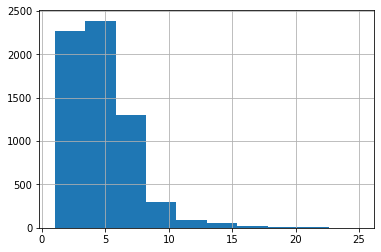

count    6427.000000
mean        4.680878
std         2.456990
min         1.000000
25%         3.000000
50%         4.000000
75%         6.000000
max        25.000000
dtype: float64

In [8]:
import pandas as pd

length = [len(e) for e in input_train + input_test]
maxlen = max(length)
seq_len = maxlen

pd.Series(length).hist()
plt.show()
pd.Series(length).describe()

In [9]:
# pad / add unknown
pad = '<PAD>'
unk = '<UNK>'

input_train_mod = list()
for sentence in input_train:
    sentence_padded = sentence
    for j in range(seq_len):
        if j >= len(sentence):
            sentence_padded.append(pad)
    input_train_mod.append(sentence_padded)

input_test_mod= list()
for sentence in input_test:
    s = []
    for j in range(seq_len):
        if j >= len(sentence):
            s.append(pad)
        else:  
            word = sentence[j]
            if word not in corpus:
                s.append(unk)
            else:
                s.append(word)
    input_test_mod.append(s)

In [10]:
len(input_train), len(input_train[1]) 

(5774, 25)

In [11]:
input_train = input_train_mod
input_test = input_test_mod

In [12]:
one_hot_encoder = {w:i+2 for i,w in enumerate(corpus)}

pad_val = 0
unk_val = 1
one_hot_encoder[pad] = pad_val
one_hot_encoder[unk] = unk_val

In [13]:
# encode
ipt_tr = []
for sentence in input_train:
    s = []
    for word in sentence:
        s.append(one_hot_encoder[word])
    ipt_tr.append(s) 

ipt_t = []
for sentence in input_test:
    s = []
    for word in sentence:
        s.append(one_hot_encoder[word])
    ipt_t.append(s) 

In [14]:
# train
ipt_tr = ipt_tr
lab_tr = label_train

# test
ipt_t = ipt_t
lab_t = label_test

In [15]:
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

train_dataset = TensorDataset(torch.tensor(ipt_tr), torch.tensor(lab_tr))
test_dataset = TensorDataset(torch.tensor(ipt_t), torch.tensor(lab_t))

# dataloaders
batch_size = 50

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

In [16]:
# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = next(dataiter)


print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print('Sample output: \n', sample_y)

Sample input size:  torch.Size([50, 25])
Sample input: 
 tensor([[5335, 2607,    0,  ...,    0,    0,    0],
        [1561, 5466,  357,  ...,    0,    0,    0],
        [2317, 3108,    0,  ...,    0,    0,    0],
        ...,
        [6655, 6061, 7124,  ...,    0,    0,    0],
        [4371, 8416, 4565,  ...,    0,    0,    0],
        [7111, 6061, 1089,  ...,    0,    0,    0]])
Sample output: 
 tensor([0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0,
        1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0,
        1, 0])


## 1.2 build model

In [17]:
import torch.nn as nn

In [18]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [19]:
# model class (self-implementation)
class lstm(nn.Module):
    def __init__(self, vocab_size, embedding_len, hidden_len, num_layers, output_len, drop_prob=0.3):
        super(lstm, self).__init__()
        self.vocab_size = vocab_size
        self.embedding_len = embedding_len
        self.hidden_len = hidden_len
        self.num_layers = num_layers
        self.output_len = output_len

        self.embed = nn.Embedding(vocab_size, embedding_len)
        self.lstm = nn.LSTM(embedding_len, hidden_len, num_layers, batch_first=True)
        self.dropout = nn.Dropout(drop_prob)
        self.fc = nn.Linear(hidden_len, output_len)
        self.sig = nn.Sigmoid()

    def forward(self, x, hidden):
        embeds = self.embed(x)
        lstm_out, hidden = self.lstm(embeds, hidden)
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_len)
        
        out = self.dropout(lstm_out)
        out = self.fc(out)
        out = self.sig(out)
        
        out = out.view(batch_size, -1)
        out = out[:,-1]

        return out, hidden

    def init_hidden(self, batch_size):
        h0 = torch.zeros((self.num_layers, batch_size, self.hidden_len)).to(device)
        c0 = torch.zeros((self.num_layers, batch_size, self.hidden_len)).to(device)
        hidden = (h0,c0)
        return hidden

In [20]:
# hyperparameters
no_layers = 2
vocab_size = len(corpus) + 2 #extra 1 for padding
embedding_dim = 64
output_dim = 1
hidden_dim = 256


model = lstm(vocab_size, embedding_dim, hidden_dim, no_layers, output_dim, drop_prob=0.3)
model.to(device)
model

lstm(
  (embed): Embedding(9067, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)

In [21]:
# loss and optimization functions
lr = 0.001
criterion = nn.BCELoss()
optimiser = torch.optim.Adam(model.parameters(), lr=lr)

c:\Users\Windows\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1.3 train and validate

In [22]:
from torchmetrics.classification import BinaryAccuracy

In [23]:
# train the model
def train():
    pass

In [24]:
# validate the result
def validate():
    pass

In [25]:
epochs = 2
counter = 0
print_every = 1000
clip = 5
valid_loss_min = np.Inf

model.train()
for i in range(epochs):
    
    h = model.init_hidden(batch_size)
    for inputs, labels in train_loader:
        counter += 1
        h = tuple([e.data for e in h])
        inputs, labels = inputs.to(device), labels.to(device)
        model.zero_grad()
        output, h = model(inputs, h)
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimiser.step()

        if counter%print_every == 0:
            val_h = model.init_hidden(batch_size)
            val_losses = []
            model.eval()
            for inp, lab in test_loader:
                val_h = tuple([each.data for each in val_h])
                inp, lab = inp.to(device), lab.to(device)
                out, val_h = model(inp, val_h)
                val_loss = criterion(out.squeeze(), lab.float())
                val_losses.append(val_loss.item())
                
            model.train()
            print("Epoch: {}/{}...".format(i+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)))
            if np.mean(val_losses) <= valid_loss_min:
                torch.save(model.state_dict(), './state_dict.pt')
                print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,np.mean(val_losses)))
                valid_loss_min = np.mean(val_losses)

IndexError: index out of range in self

In [ ]:
# Loading the best model
model.load_state_dict(torch.load('./state_dict.pt'))

test_losses = []
num_correct = 0
h = model.init_hidden(batch_size)

model.eval()
for inputs, labels in test_loader:
    h = tuple([each.data for each in h])
    inputs, labels = inputs.to(device), labels.to(device)
    output, h = model(inputs, h)
    test_loss = criterion(output.squeeze(), labels.float())
    test_losses.append(test_loss.item())
    pred = torch.round(output.squeeze())  # Rounds the output to 0/1
    correct_tensor = pred.eq(labels.float().view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    num_correct += np.sum(correct)

print("Test loss: {:.3f}".format(np.mean(test_losses)))
test_acc = num_correct/len(test_loader.dataset)
print("Test accuracy: {:.3f} %".format(test_acc*100))

Test loss: 0.689
Test accuracy: 33.384 %


In [ ]:
num_epochs = 3
num_clips = 5

for epoch in range(1, num_epochs+1):
    l = []
    model.train()
    
    h = model.init_hidden(batch_size)
    for inputs, labels in train_loader:
        
        inputs, labels = inputs.to(device), labels.to(device)
        h = tuple([each.data for each in h])
        
        model.zero_grad()
        out,h  = model(inputs, h)
    
        loss = criterion(out.squeeze(), labels.float())
        loss.backward()
        l.append(loss.item())

        metric = BinaryAccuracy()
        val_accuracy = metric(out, labels)

        nn.utils.clip_grad_norm(model.parameters(), num_clips)
        optimiser.step()
    

    '''
    model.eval()
    
    val_h = model.init_hidden(batch_size)
    for inputs, labels in val_loader:

        val_inputs, val_labels = inputs.to(device), labels.to(device)
        val_h = tuple([each.data for each in val_h])

        val_out,val_h = model(val_inputs, val_h)
        val_loss = criterion(val_out.squeeze(), val_labels.float())

        metric = BinaryAccuracy()
        val_accuracy = metric(out, labels)
        optimizer.step()
    '''
    

    print("Epoch: %d, accuracy: %1.5f" % (epoch, accuracy)) 
    print('loss: %1.5f' % (np.mean(l)))
    print(20*'==')

C:\Users\Windows\AppData\Local\Temp\ipykernel_16568\893722384.py:24: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(model.parameters(), num_clips)


IndexError: index out of range in self

https://medium.com/@khang.pham.exxact/hugging-face-text-classification-tutorial-using-pytorch-cd3d6bc33292

## 1.4. model evaluation visulisation

NameError: name 'epoch_tr_acc' is not defined

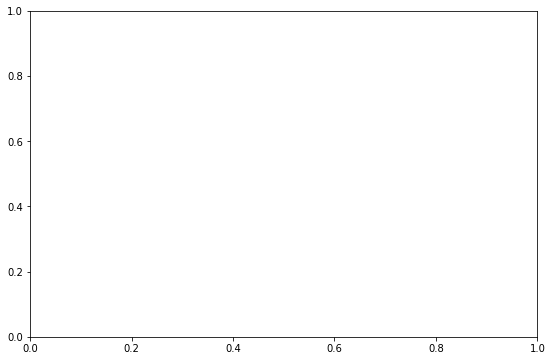

In [ ]:
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc')
plt.plot(epoch_vl_acc, label='Validation Acc')
plt.title("Accuracy")
plt.legend()
plt.grid()
   
plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_vl_loss, label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()


plt.show()

## 1.5 testing and prediction